In [1]:
import urllib.request
import json
import geopandas as gpd
import pandas as pd

df = pd.read_csv('test.csv')

def API_Request(Stations, SubscriptionKey):
    # API Headers
    url = f"https://gateway.apiportal.ns.nl/Spoorkaart-API/api/v1/traject.geojson?stations={Stations}"
    headers = {
        'Cache-Control': 'no-cache',
        'Ocp-Apim-Subscription-Key': SubscriptionKey,
    }

    # Make the API request
    try:
        req = urllib.request.Request(url, headers=headers)
        response = urllib.request.urlopen(req)
        response_content = response.read().decode('utf-8')

        # Load the response content into JSON
        geojson_data = json.loads(response_content)

        # Convert the GeoJSON data to a GeoDataFrame
        gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

        return gdf
    except urllib.error.HTTPError as e:
        print(f"HTTPError: {e.code} - {e.reason}")
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None

# Loop through the DataFrame and make API requests
geometry_data = []

for i in range(len(df)):
    while True:
        try:
            # Make the API request
            geodata = API_Request(f'{df["From"][i]},{df["To"][i]}', SubscriptionKey)
            
            # If the API request is successful, add geometry data and break out of the loop
            if geodata is not None:
                geometry_data.append(geodata['geometry'].iloc[0])
                print(i)
                break
            else:
                # If the API fails, prompt for a new subscription key
                SubscriptionKey = input('Invalid SubscriptionKey. Please enter a new SubscriptionKey: ')
        except Exception as e:
            print(f"An error occurred: {e}")
            SubscriptionKey = input('Error occurred. Please enter a new SubscriptionKey: ')


An error occurred: name 'SubscriptionKey' is not defined
HTTPError: 401 - Unauthorized
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255

In [9]:
df['geometry'] = geometry_data
df = gpd.GeoDataFrame(df, geometry='geometry')

df.to_csv('Geodata.csv')

In [11]:
count = 0
for i in range(len(df)):
    if df.loc[i, 'geometry'] == None:
        count += 1
        print(i)
print(count)

0


<Axes: >

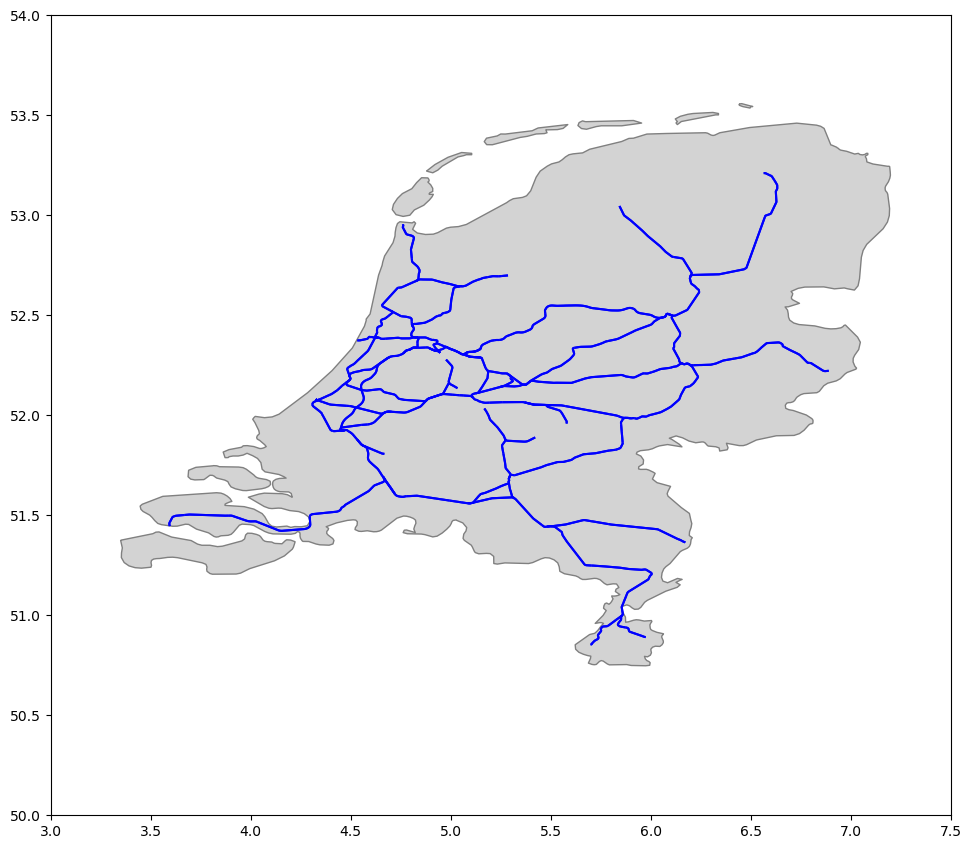

In [7]:
import matplotlib.pyplot as plt

#Nederland plotten
netherlands_shapefile_path = "ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
world = gpd.read_file(netherlands_shapefile_path)
netherlands = world[world['NAME'] == "Netherlands"]
fig = plt.figure(figsize=[12,8])
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlim([3,7.5])
ax.set_ylim([50,54])
netherlands.plot(ax=ax,  color='lightgray', edgecolor = 'gray')

df.plot(ax=ax, color = 'blue')

In [8]:
import folium
import geopandas as gpd

# Function to plot GeoDataFrame interactively using Folium
def plot_folium(gdf):
    # Step 1: Create a base Folium map
    # Initialize the map centered on the mean of the coordinates
    m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=8)

    # Step 2: Add each geometry (LineString or Polygon) to the map
    folium.GeoJson(gdf).add_to(m)

    # Step 3: Return the map for interactive display
    return m

# Example: Plotting the previously created GeoDataFrame (gdf_routes)
map_interactive = plot_folium(df.set_crs(epsg=4326))

# Step 4: Display the map (if running in a notebook environment, this will display the map)
map_interactive

C:\Users\thijs\AppData\Local\Temp\ipykernel_29580\3980159523.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=8)


In [51]:
# function to assign a color to a number based on where in the range of numbers it lies
def interpolate_color(lower_limit, upper_limit, lower_color, upper_color, number):
    # Clamp the number between the lower and upper limit
    number = max(min(number, upper_limit), lower_limit)
    
    # Calculate the interpolation factor
    factor = (number - lower_limit) / (upper_limit - lower_limit)
    
    # Interpolate each RGB component
    interpolated_color = tuple(
        int(lower_component + (upper_component - lower_component) * factor)
        for lower_component, upper_component in zip(lower_color, upper_color)
    )
    
    #normalize the color for usage
    color = [interpolated_color / 255.0 for interpolated_color in interpolated_color] 

    return str(color)

In [52]:
df['color'] = 0
for i in range(len(df)):
    print(interpolate_color(df['Seats'].min(), df['Seats'].max(), (0,0,255), (255,0,0), df.loc[i, 'Seats']))
    print(type(interpolate_color(df['Seats'].min(), df['Seats'].max(), (0,0,255), (255,0,0), df.loc[i, 'Seats'])))
    df.loc[i, 'color'] = interpolate_color(df['Seats'].min(), df['Seats'].max(), (0,0,255), (255,0,0), df.loc[i, 'Seats'])
display(df)

[0.10196078431372549, 0.0, 0.8941176470588236]
<class 'str'>
[0.10196078431372549, 0.0, 0.8941176470588236]
<class 'str'>
[0.09803921568627451, 0.0, 0.8980392156862745]
<class 'str'>
[0.10196078431372549, 0.0, 0.8941176470588236]
<class 'str'>
[0.10196078431372549, 0.0, 0.8941176470588236]
<class 'str'>
[0.10196078431372549, 0.0, 0.8941176470588236]
<class 'str'>
[0.18823529411764706, 0.0, 0.807843137254902]
<class 'str'>
[0.12156862745098039, 0.0, 0.8745098039215686]
<class 'str'>
[0.12156862745098039, 0.0, 0.8745098039215686]
<class 'str'>
[0.12156862745098039, 0.0, 0.8745098039215686]
<class 'str'>
[0.12156862745098039, 0.0, 0.8745098039215686]
<class 'str'>
[0.12156862745098039, 0.0, 0.8745098039215686]
<class 'str'>
[0.12156862745098039, 0.0, 0.8745098039215686]
<class 'str'>
[0.12156862745098039, 0.0, 0.8745098039215686]
<class 'str'>
[0.12156862745098039, 0.0, 0.8745098039215686]
<class 'str'>
[0.13725490196078433, 0.0, 0.8588235294117647]
<class 'str'>
[0.1411764705882353, 0.0,

C:\Users\thijs\AppData\Local\Temp\ipykernel_29580\2038396080.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.10196078431372549, 0.0, 0.8941176470588236]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'color'] = interpolate_color(df['Seats'].min(), df['Seats'].max(), (0,0,255), (255,0,0), df.loc[i, 'Seats'])


,Unnamed: 0,From,To,Seats,geometry,color
0,0,Gn,Gerp,191610.0,"LINESTRING (6.56471 53.21065, 6.56834 53.21078...","[0.10196078431372549, 0.0, 0.8941176470588236]"
1,1,Gerp,Hrn,191760.0,"LINESTRING (6.58546 53.20483, 6.58697 53.20406...","[0.10196078431372549, 0.0, 0.8941176470588236]"
2,2,Hrn,Asn,184835.0,"LINESTRING (6.61751 53.17617, 6.61841 53.17478...","[0.09803921568627451, 0.0, 0.8980392156862745]"
3,3,Asn,Bl,187410.0,"LINESTRING (6.57107 52.99163, 6.57048 52.99002...","[0.10196078431372549, 0.0, 0.8941176470588236]"
4,4,Bl,Hgv,187410.0,"LINESTRING (6.5212 52.8547, 6.52046 52.8527, 6...","[0.10196078431372549, 0.0, 0.8941176470588236]"
...,...,...,...,...,...,...
565,565,Ldl,Ledn,135648.0,"LINESTRING (4.49242 52.14686, 4.49093 52.14736...","[0.06666666666666667, 0.0, 0.9294117647058824]"
566,566,Ledn,Ldl,132408.0,"LINESTRING (4.48171 52.16608, 4.48115 52.16566...","[0.06666666666666667, 0.0, 0.9294117647058824]"
567,567,Ldl,Apn,132408.0,"LINESTRING (4.49242 52.14686, 4.49664 52.14538...","[0.06666666666666667, 0.0, 0.9294117647058824]"
568,568,Apn,Bdg,132408.0,"LINESTRING (4.65757 52.12436, 4.6641 52.11805,...","[0.06666666666666667, 0.0, 0.9294117647058824]"


In [53]:
import pandas as pd

# Assuming 'df' is already defined and 'Seats' column exists

# Initialize the 'color' column with empty lists or None
df['color'] = None

# Loop through the DataFrame to assign colors
for i in range(len(df)):
    # Compute the interpolated color and store it in the DataFrame
    df.loc[i, 'color'] = interpolate_color(
        df['Seats'].min(),
        df['Seats'].max(),
        (0, 0, 255),  # RGB color for blue
        (255, 0, 0),  # RGB color for red
        df.loc[i, 'Seats']  # Current seat value
    )

# Display the updated DataFrame
display(df)


,Unnamed: 0,From,To,Seats,geometry,color
0,0,Gn,Gerp,191610.0,"LINESTRING (6.56471 53.21065, 6.56834 53.21078...","[0.10196078431372549, 0.0, 0.8941176470588236]"
1,1,Gerp,Hrn,191760.0,"LINESTRING (6.58546 53.20483, 6.58697 53.20406...","[0.10196078431372549, 0.0, 0.8941176470588236]"
2,2,Hrn,Asn,184835.0,"LINESTRING (6.61751 53.17617, 6.61841 53.17478...","[0.09803921568627451, 0.0, 0.8980392156862745]"
3,3,Asn,Bl,187410.0,"LINESTRING (6.57107 52.99163, 6.57048 52.99002...","[0.10196078431372549, 0.0, 0.8941176470588236]"
4,4,Bl,Hgv,187410.0,"LINESTRING (6.5212 52.8547, 6.52046 52.8527, 6...","[0.10196078431372549, 0.0, 0.8941176470588236]"
...,...,...,...,...,...,...
565,565,Ldl,Ledn,135648.0,"LINESTRING (4.49242 52.14686, 4.49093 52.14736...","[0.06666666666666667, 0.0, 0.9294117647058824]"
566,566,Ledn,Ldl,132408.0,"LINESTRING (4.48171 52.16608, 4.48115 52.16566...","[0.06666666666666667, 0.0, 0.9294117647058824]"
567,567,Ldl,Apn,132408.0,"LINESTRING (4.49242 52.14686, 4.49664 52.14538...","[0.06666666666666667, 0.0, 0.9294117647058824]"
568,568,Apn,Bdg,132408.0,"LINESTRING (4.65757 52.12436, 4.6641 52.11805,...","[0.06666666666666667, 0.0, 0.9294117647058824]"


c:\Users\thijs\anaconda3\envs\TIL6022\Lib\site-packages\geopandas\plotting.py:968: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
c:\Users\thijs\anaconda3\envs\TIL6022\Lib\site-packages\geopandas\plotting.py:968: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
c:\Users\thijs\anaconda3\envs\TIL6022\Lib\site-packages\geopandas\plotting.py:968: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
c:\Users\thijs\anaconda3\envs\TIL6022\Lib\site-packages\geopandas\plotting.py:968: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
c:\Users\thijs\anaco

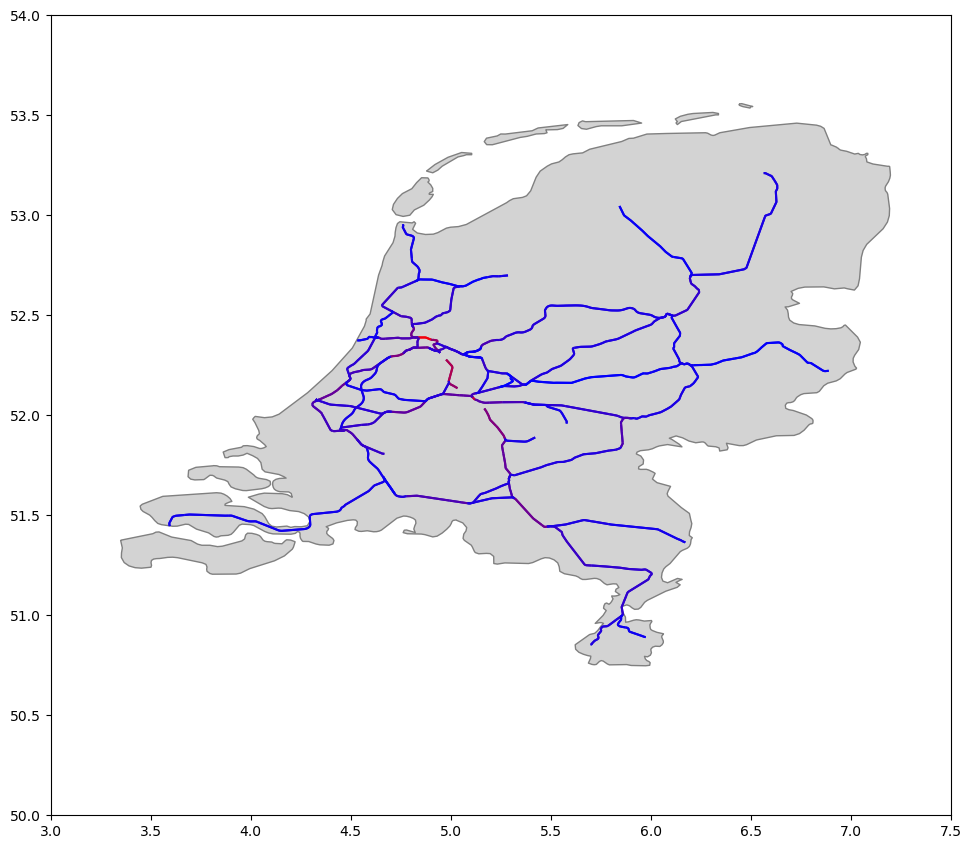

In [59]:
import matplotlib.pyplot as plt
import ast

#Nederland plotten
netherlands_shapefile_path = "ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
world = gpd.read_file(netherlands_shapefile_path)
netherlands = world[world['NAME'] == "Netherlands"]
fig = plt.figure(figsize=[12,8])
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlim([3,7.5])
ax.set_ylim([50,54])
netherlands.plot(ax=ax,  color='lightgray', edgecolor = 'gray')

for i in range(len(df)):
    df.iloc[[i]].plot(ax=ax, color = ast.literal_eval((df.loc[i, 'color'])))